# Desafio de Classificação

Análise de antifraude - Usando CPU e GPU

# Solução usando CPU

In [4]:
# Data analysis libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Modelling libs
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [12]:
#Funções
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

### Importando os dados

In [6]:
%%time
df = pd.read_csv('fraud_detection_dataset.csv')
print(df.shape)
print(df.head())

(6362620, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
Wall time: 7.2 s


### Análise Exploratória

In [7]:
%%time
target = 'isFraud'
num_features = df.select_dtypes(include=['int', 'float']).columns.tolist()
num_features = [i for i in num_features if i not in [target]]
print(num_features)

['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
Wall time: 0 ns


O dataset é seriamente desbalanceado

In [7]:
%%time
#% de fraudes
df.isFraud.mean()*100

Wall time: 8 ms


0.12908204481801522

Análise de variáveis numéricas - percebe que amount tende a ser menor para fraudes, e o que mesmo se aplica para as variáveis de saldo

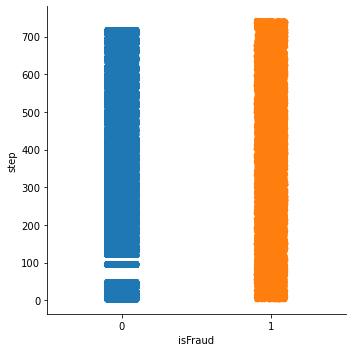

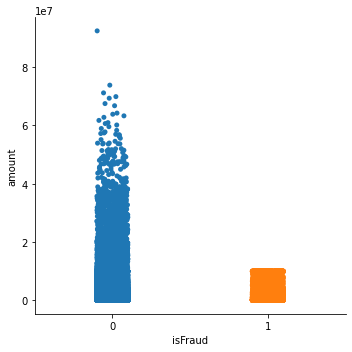

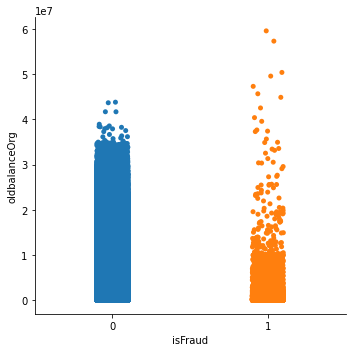

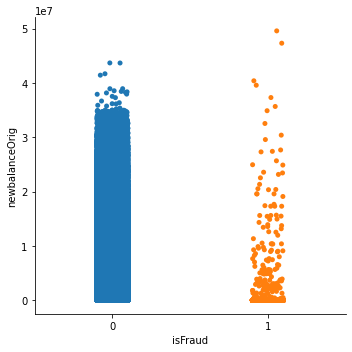

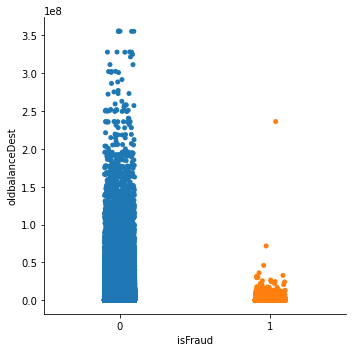

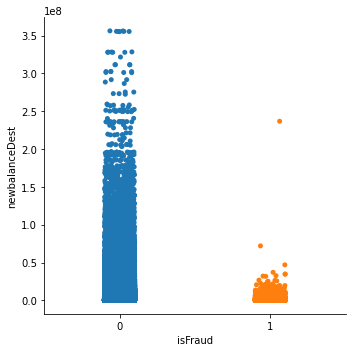

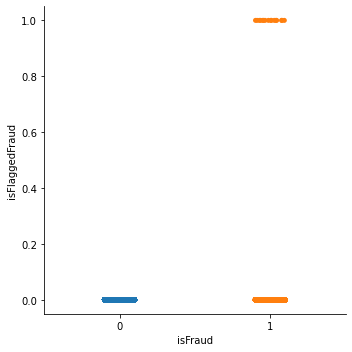

Wall time: 3min 41s


In [8]:
%%time
for i in num_features:
    sns.catplot(data = df, x = target, y = i)
    plt.show()

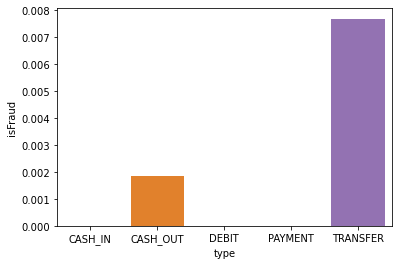

Wall time: 388 ms


In [9]:
%%time
sns.barplot(data = df.groupby('type')[target].mean().reset_index(), x = 'type', y = target)
plt.show()

In [10]:
%%time
#Checando nulos
df.isnull().sum()

Wall time: 1.69 s


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Modelagem

In [8]:
%%time
#Train test split
X = df[num_features + ['type']]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Wall time: 1.31 s


In [9]:
%%time
#Transformando 'type' em dummies
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

Wall time: 536 ms


### Logistic Regression

In [11]:
%%time
#Fitting
logistic_model = LogisticRegression(random_state = 42)
logistic_model.fit(X_train, y_train)

Wall time: 38.9 s


LogisticRegression(random_state=42)

Apesar da acurácia ser alta, o modelo não identifica 0.07% das fraudes (o recall pode ser inaceitável)

Wall time: 413 ms


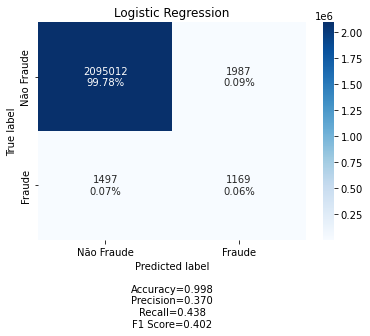

In [14]:
%%time
make_confusion_matrix(metrics.confusion_matrix(y_test, logistic_model.predict(X_test)), categories = ['Não Fraude', 'Fraude'], title = "Logistic Regression")

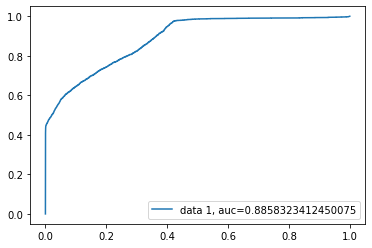

Wall time: 1.21 s


In [13]:
%%time
#AOC Curve
y_pred_proba = logistic_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Random Forest

O RF obtém uma precisão de quase 100% (melhor que logit), porém é menos eficiente

In [14]:
%%time
#Fitting
rf = RandomForestClassifier(random_state = 42, n_estimators = 8)
rf.fit(X_train, y_train)

Wall time: 39.8 s


RandomForestClassifier(n_estimators=8, random_state=42)

Wall time: 1.51 s


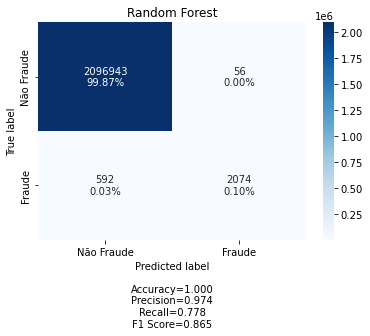

In [15]:
%%time
make_confusion_matrix(metrics.confusion_matrix(y_test, rf.predict(X_test)), categories = ['Não Fraude', 'Fraude'], title = "Random Forest")

# Solução com GPU

Nesse computador não consigo instalar as bibliotecas RAPID. Porém o resultado seria o mesmo, com performance maior